In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

# 生成数据集

⽣成⼀个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。我们的合成数据集是⼀个矩阵X ∈ R^1000×2。  
使⽤线性模型参数w = [2, −3.4]⊤、b = 4.2 和噪声项ϵ⽣成数据集及其标签：  
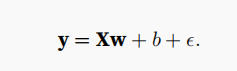  
ϵ可以视为模型预测和标签时的潜在观测误差。ϵ服从均值为0的正态分布。

In [2]:
def synthetic_data(w, b, num_examples): #@save
    """⽣成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
#features中的每⼀⾏都包含⼀个⼆维数据样本，labels中的每⼀⾏都包含⼀维标签值（⼀个标量）
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.0745,  0.4803]) 
label: tensor([2.4111])


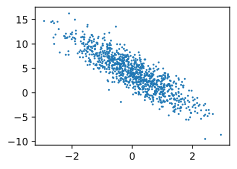

In [5]:
#可视化
#通过⽣成第⼆个特征features[:, 1]和labels的散点图，可以直观观察到两者之间的线性关系
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

# 读取数据集

定义⼀个data_iter函数，该函数接收批量⼤⼩、特征矩阵和标签向量作为输⼊，⽣成⼤⼩为batch_size的⼩批量。每个⼩批量包含⼀组特征和标签。

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [7]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.1831, -0.5743],
        [-1.2991, -0.3904],
        [ 0.6472,  0.0250],
        [ 0.6978, -1.9946],
        [ 1.2586,  1.3706],
        [-1.1741,  1.4062],
        [-1.5041, -1.1043],
        [ 0.5827, -0.3203],
        [-0.7621,  1.5254],
        [-0.4312,  0.3039]]) 
 tensor([[ 5.7977],
        [ 2.9127],
        [ 5.3999],
        [12.3731],
        [ 2.0520],
        [-2.9017],
        [ 4.9267],
        [ 6.4618],
        [-2.5121],
        [ 2.2844]])


# 初始化模型参数

⼩批量随机梯度下降优化模型参数之前，需要先有⼀些参数，通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重w，并将偏置b初始化为0。

In [8]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 定义模型

In [9]:
def linreg(X, w, b): #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

## 定义损失函数

In [11]:
def squared_loss(y_hat, y): #@save
    """均⽅损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法

⼩批量随机梯度下降：在每⼀步中，使⽤从数据集中随机抽取的⼀个⼩批量，然后根据参数计算损失的梯度。接下来，朝着减少损失的⽅向更新我们的参数。下⾯的函数实现⼩批量随机梯度下降更新。该函数接受模型参数集合、学习速率和
批量⼤⼩作为输⼊。每⼀步更新的⼤⼩由学习速率lr决定。因为我们计算的损失是⼀个批量样本的总和，所以我们⽤批量⼤⼩（batch_size）来规范化步⻓，这样步⻓⼤⼩就不会取决于我们对批量⼤⼩的选择。

In [15]:
def sgd(params, lr, batch_size): #@save
    """⼩批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


## 训练
在每次迭代中，我们读取⼀⼩批量训练样本，并通过我们的模型来获得⼀组预测。计算完损失后，我们开始反向传播，存储每个参数的梯度。最后，我们调⽤优化算法sgd来更新模型参数。  
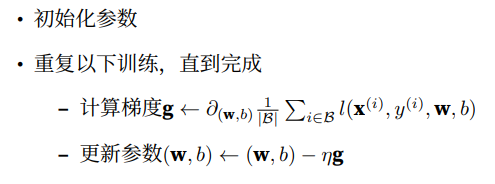

在每个迭代周期（epoch）中，我们使⽤data_iter函数遍历整个数据集，并将训练数据集中所有样本都使⽤⼀次（假设样本数能够被批量⼤⼩整除）。这⾥的迭代周期个数num_epochs和学习率lr都是超参数，分别设为3和0.03。设置超参数很棘⼿，需要通过反复试验进⾏调整。

In [13]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [16]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的⼩批量损失
        # 因为l形状是(batch_size,1)，⽽不是⼀个标量。l中的所有元素被加到⼀起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使⽤参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')


epoch 1, loss 0.035668
epoch 2, loss 0.000146
epoch 3, loss 0.000051


In [17]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')


w的估计误差: tensor([0.0007, 0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)
